In [1]:
import sys
sys.path.append('../')

from low_rank_rnns.modules import *
from low_rank_rnns import TF, stats, plotting as plot, helpers, rankone, ranktwo, rankthree, clustering
%matplotlib notebook


In [2]:
size = 100
noise_std = 5e-2
alpha = .2
lr = 1e-2
hidden_size = size
rank = 3

In [3]:
# load model
x_train, y_train, mask_train, cohAll_train, x_val, y_val, mask_val, cohAll_val = TF.generate_checker_data(5000)

net = FullRankRNN(3, size, 1, noise_std, alpha)
net.load_state_dict(torch.load(f'../models/TF{size}.pt', map_location='cpu'))

<All keys matched successfully>

# process traj data for dpca 

In [4]:
loss, acc, out, decisions, target_decisions, traj = TF.test_checker(net, x_val, y_val, mask_val)

traj1 = traj.detach().numpy()
fr = traj1
# fr = np.tanh(traj1)
decisions1 = decisions.detach().numpy()

tfRL = fr[np.logical_and(decisions1 == -1, cohAll_val > 0),:,:]
tfRR = fr[np.logical_and(decisions1 == 1, cohAll_val > 0),:,:]
tfGL = fr[np.logical_and(decisions1 == -1, cohAll_val < 0),:,:]
tfGR = fr[np.logical_and(decisions1 == 1, cohAll_val < 0),:,:]

In [5]:
tfRL.shape

(232, 211, 100)

In [6]:
totalDataframe = np.zeros([fr.shape[2], 2,2,fr.shape[1]])
for n in range(fr.shape[2]):
    totalDataframe[n,0,0,:] = np.mean(tfRL,axis = 0)[:,n]
    totalDataframe[n,0,1,:] = np.mean(tfRR,axis = 0)[:,n]
    totalDataframe[n,1,0,:] = np.mean(tfGL,axis = 0)[:,n]
    totalDataframe[n,1,1,:] = np.mean(tfGR,axis = 0)[:,n]


# save dataframe as mat file 
import scipy.io
mdic = {'totalDataframe': totalDataframe}
scipy.io.savemat('../totalDataframe.mat', mdic)

In [7]:

# reduce the rank of connectivity matrix 
wi_init = net.wi_full.detach()
wo_init = net.wo_full.detach() * hidden_size
print(wo_init.std())
wrec = net.wrec.detach().cpu().numpy()
# u, s, v = np.linalg.svd(wrec)
# m_init = torch.from_numpy(s[:rank] * u[:, :rank]).to(device=net.wrec.device) * sqrt(hidden_size)
# n_init = torch.from_numpy(v[:rank, :].transpose()).to(device=net.wrec.device) * sqrt(hidden_size)



m_dpca = scipy.io.loadmat('m.mat')["m"] * sqrt(hidden_size)
n_dpca = scipy.io.loadmat('n.mat')["n"] * sqrt(hidden_size)

m_init = torch.from_numpy(m_dpca)
n_init = torch.from_numpy(n_dpca)


print(m_init.std())
print(n_init.std())

print(m_init.shape)
print(n_init.shape)

tensor(7.2830)
tensor(5.0773, dtype=torch.float64)
tensor(1.0017, dtype=torch.float64)
torch.Size([100, 3])
torch.Size([100, 3])


In [8]:
# get the m matrix 
check_m = m_init.detach().numpy()


# train a low-rank RNN

In [32]:

# We see that the rank-1 network 
net_lo = LowRankRNN(3, hidden_size, 1, noise_std, alpha, rank=rank, train_m = False, wi_init=wi_init, wo_init=wo_init, m_init=m_init, n_init=n_init)
# net = LowRankRNN(1, hidden_size, 1, noise_std, alpha, rank=2)
train(net_lo, x_train, y_train, mask_train, n_epochs=20, lr=lr, batch_size=50, keep_best=True, cuda=True, clip_gradient=1, early_stop=0.2)
x_val, y_val, mask_val = map_device([x_val, y_val, mask_val], net_lo)
# out = net_lo.forward(x_val)
# print("Final loss: {:.3f}".format(loss_mse(out, y_val, mask_val)))

loss, acc, out, decisions, target_decisions, traj = TF.test_checker(net_lo, x_val, y_val, mask_val)
print(f'loss={loss:.3f}, acc={acc:.3f}')

# torch.save(net_lo.state_dict(), "../models/TF_rank3_{}.pt".format(hidden_size))


Training...
initial loss: 0.662
epoch 0:  loss=0.461  (took 10.47 s) *
epoch 1:  loss=0.264  (took 10.59 s) *
epoch 2:  loss=0.144  (took 10.69 s) *
loss=0.130, acc=0.988


In [33]:
m_low = net_lo.m.detach().numpy()


In [34]:
print(np.sum(check_m - m_low))


-1.375524765076519e-06


In [35]:
# 

<IPython.core.display.Javascript object>


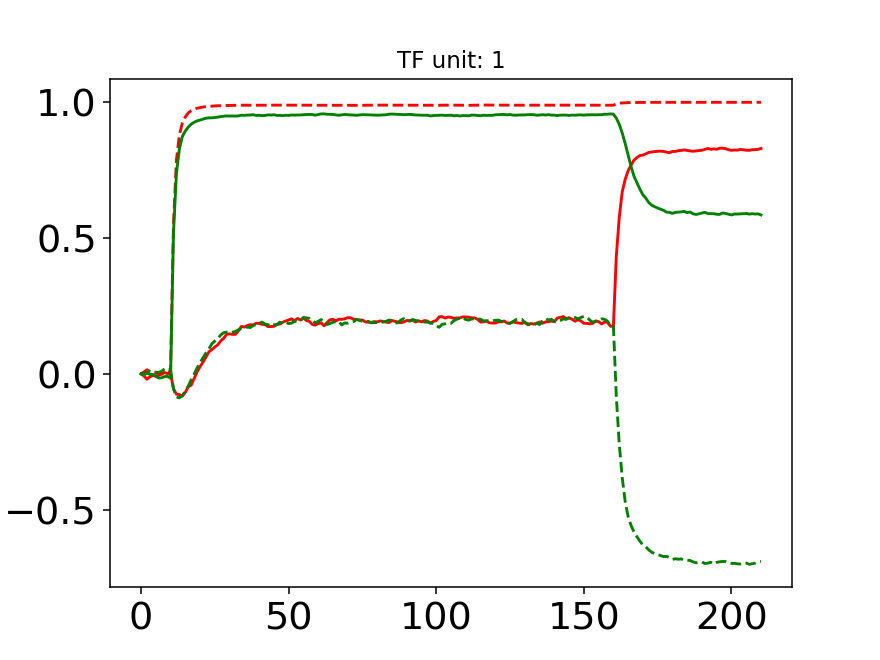

<IPython.core.display.Javascript object>


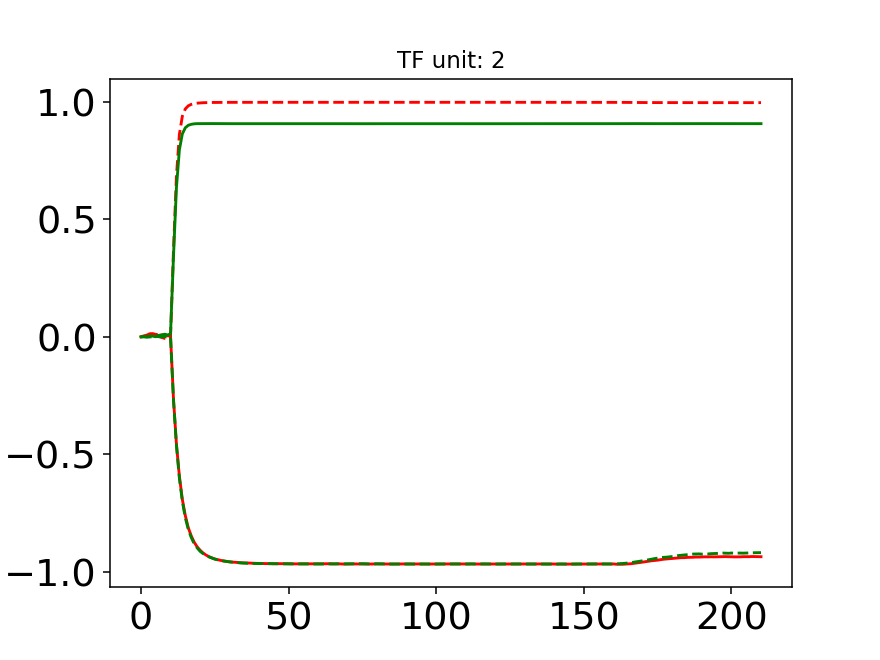

<IPython.core.display.Javascript object>


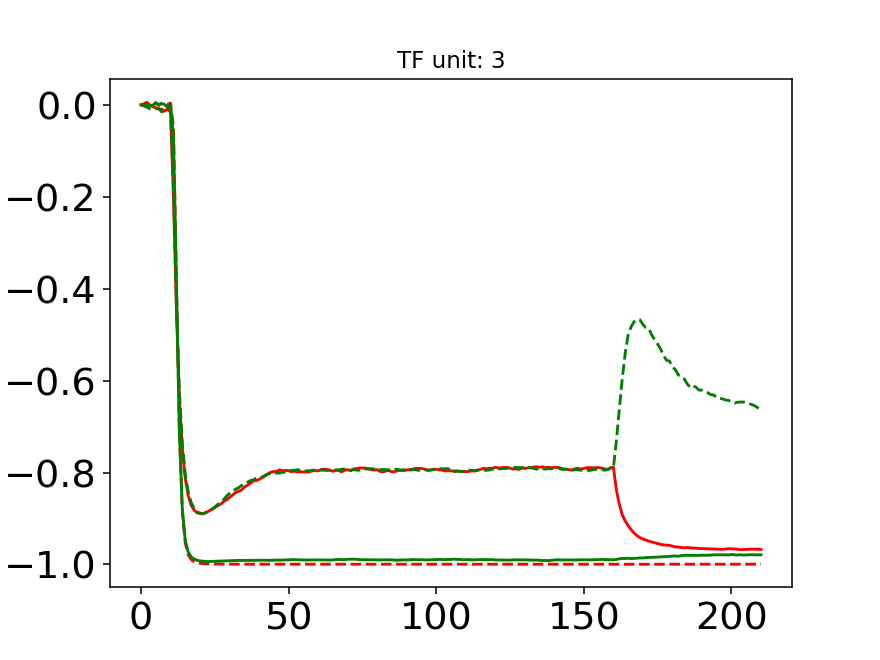

<IPython.core.display.Javascript object>


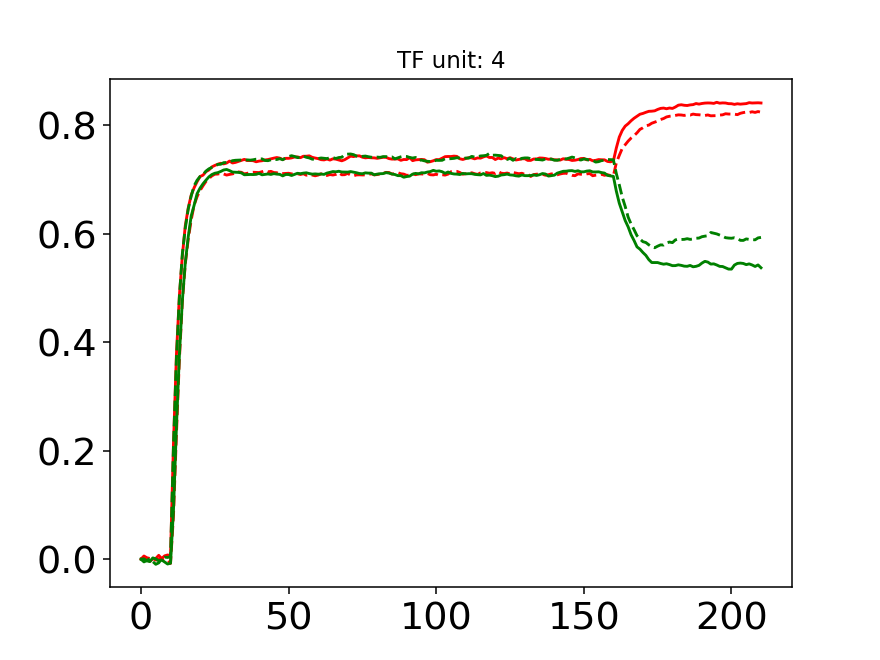

<IPython.core.display.Javascript object>


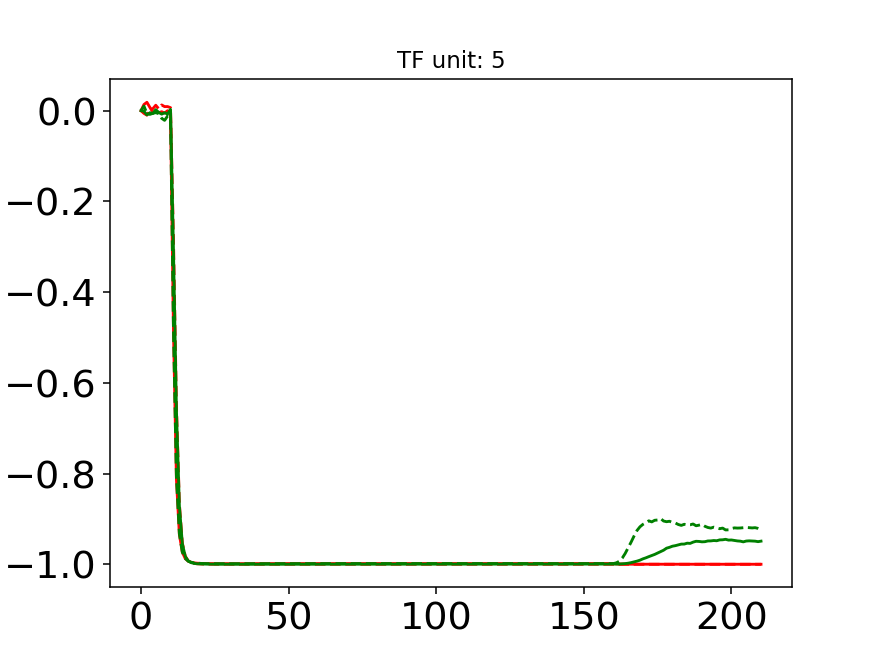

<IPython.core.display.Javascript object>


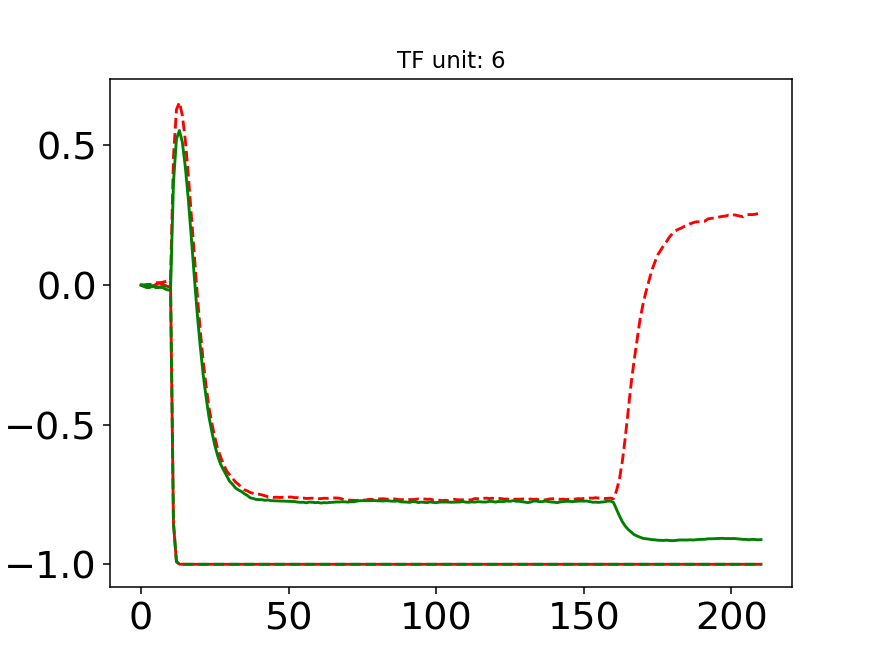

<IPython.core.display.Javascript object>


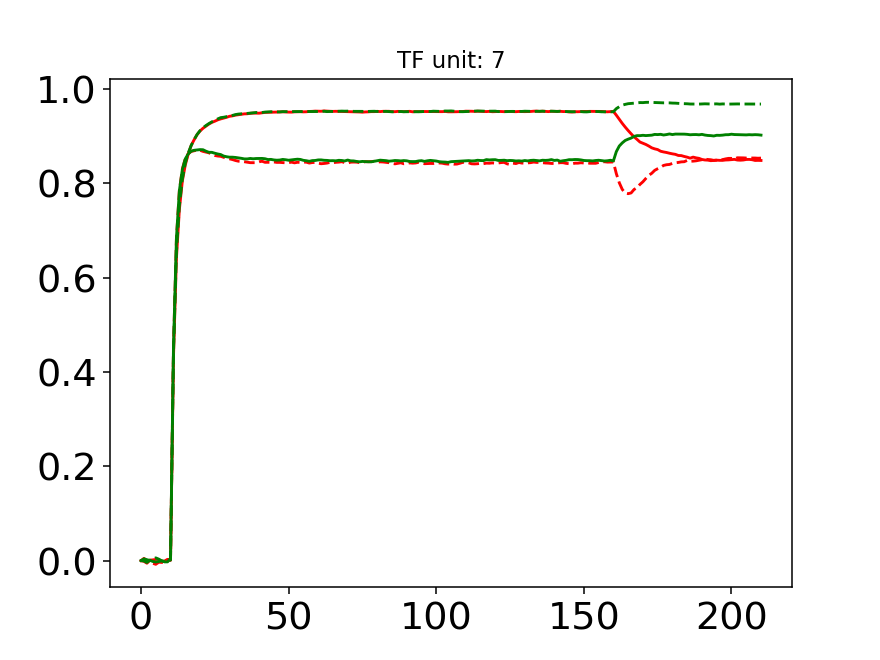

<IPython.core.display.Javascript object>


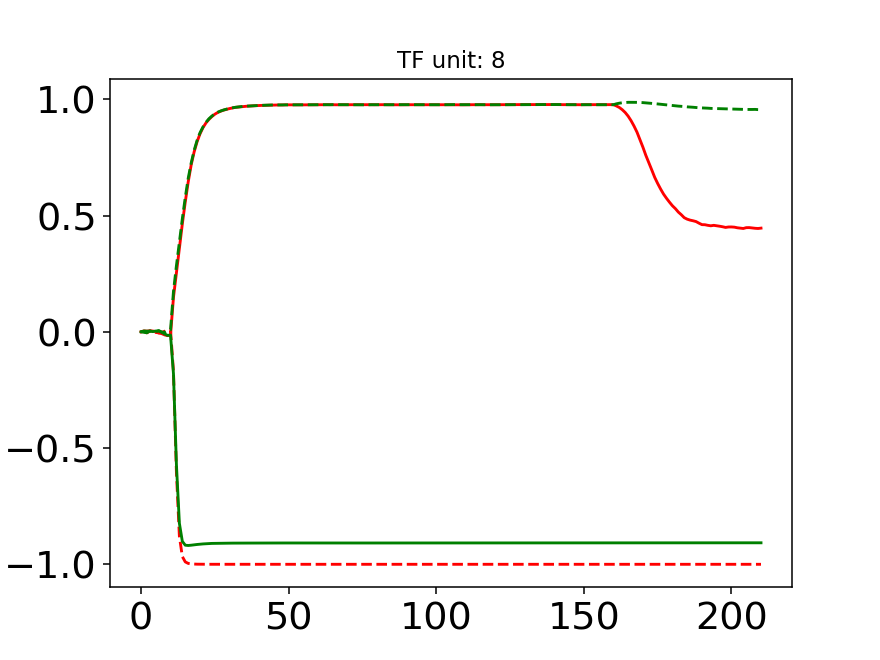

<IPython.core.display.Javascript object>


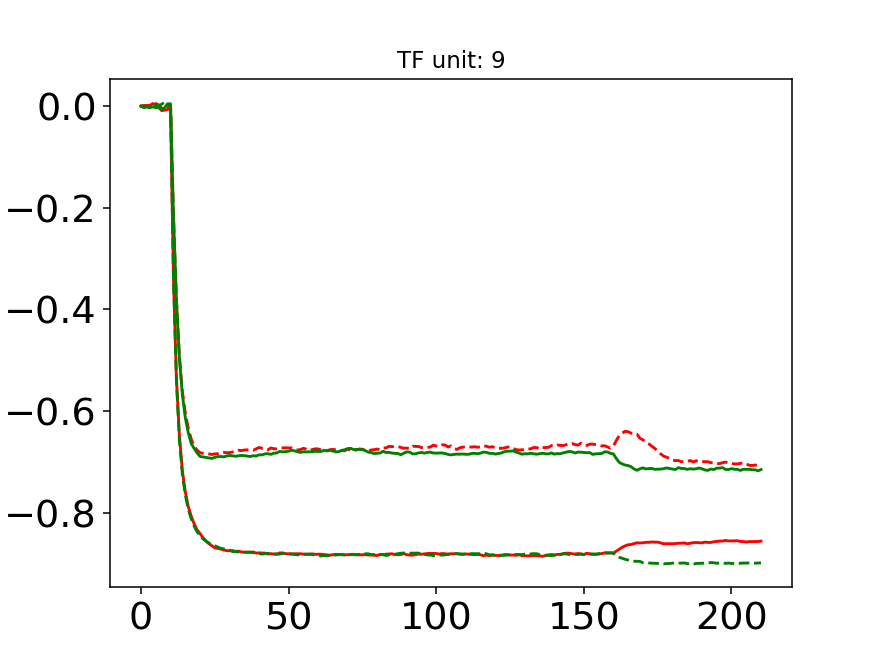

In [36]:
traj1 = traj.detach().numpy()

traj1 = np.tanh(traj1)
decisions1 = decisions.detach().numpy()

tfRL = traj1[np.logical_and(decisions1 == -1, cohAll_val > 0),:,:]
tfRR = traj1[np.logical_and(decisions1 == 1, cohAll_val > 0),:,:]
tfGL = traj1[np.logical_and(decisions1 == -1, cohAll_val < 0),:,:]
tfGR = traj1[np.logical_and(decisions1 == 1, cohAll_val < 0),:,:]

trajLow = np.zeros((4, tfRL.shape[1], tfRL.shape[2]))
trajLow[0,:,:] = np.mean(tfRL,axis = 0)
trajLow[1,:,:] =np.mean(tfRR,axis = 0)
trajLow[2,:,:] =np.mean(tfGL,axis = 0)
trajLow[3,:,:] =np.mean(tfGR,axis = 0)

for n in range(1,10):
    plt.figure()
    plt.plot(np.mean(tfRL,axis = 0)[:,n], 'r-')
    plt.plot(np.mean(tfRR,axis = 0)[:,n], 'r--')
    plt.plot(np.mean(tfGL,axis = 0)[:,n], 'g-')
    plt.plot(np.mean(tfGR,axis = 0)[:,n], 'g--')
    plt.title("TF unit: " + str(n))

In [37]:
# net_lo.svd_reparametrization()

# net_lo.svd_reparametrization()
wi1 = net_lo.wi[0].detach().numpy()
wi2 = net_lo.wi[1].detach().numpy()
wi3 = net_lo.wi[2].detach().numpy()
# n: low-rank Wrec connectivity vector n
n1 = net_lo.n[:, 0].detach().numpy()
n2 = net_lo.n[:, 1].detach().numpy()
n3 = net_lo.n[:, 2].detach().numpy()
# m: low-rank Wrec connectivity vector m
m1 = net_lo.m[:, 0].detach().numpy()
m2 = net_lo.m[:, 1].detach().numpy()
m3 = net_lo.m[:, 2].detach().numpy()
wo = net_lo.wo.detach().squeeze().numpy()

In [38]:
# # generate 4 trials, each represent a condition
# x = TF.generate_ordered_inputs()

# _, trajFull = net.forward(x, return_dynamics=True)
# _, trajLow = net_lo.forward(x, return_dynamics=True)

# trajFull = trajFull.detach().numpy()
# trajLow = trajLow.detach().numpy()

In [16]:

# for ii in range(10,20):
#     plt.figure()
#     plt.plot(trajLow[0,:,ii], 'r-')
#     plt.plot(trajLow[1,:,ii], 'r--')
#     plt.plot(trajLow[2,:,ii], 'g-')
#     plt.plot(trajLow[3,:,ii], 'g--')
#     plt.show()

In [39]:
totalDataframeLow = np.zeros([trajLow.shape[2], 2,2,fr.shape[1]])
for n in range(trajLow.shape[2]):
    totalDataframeLow[n,0,0,:] = trajLow[0,:,n]
    totalDataframeLow[n,0,1,:] = trajLow[1,:,n]
    totalDataframeLow[n,1,0,:] = trajLow[2,:,n]
    totalDataframeLow[n,1,1,:] = trajLow[3,:,n]    
# save dataframe as mat file 
import scipy.io
mdic = {'totalDataframeLow': totalDataframeLow}
scipy.io.savemat('../totalDataframeLow.mat', mdic)

In [30]:
trajLow.shape

(4, 211, 100)

In [28]:
totalDataframeLow.shape

(100, 2, 2, 211)

<IPython.core.display.Javascript object>


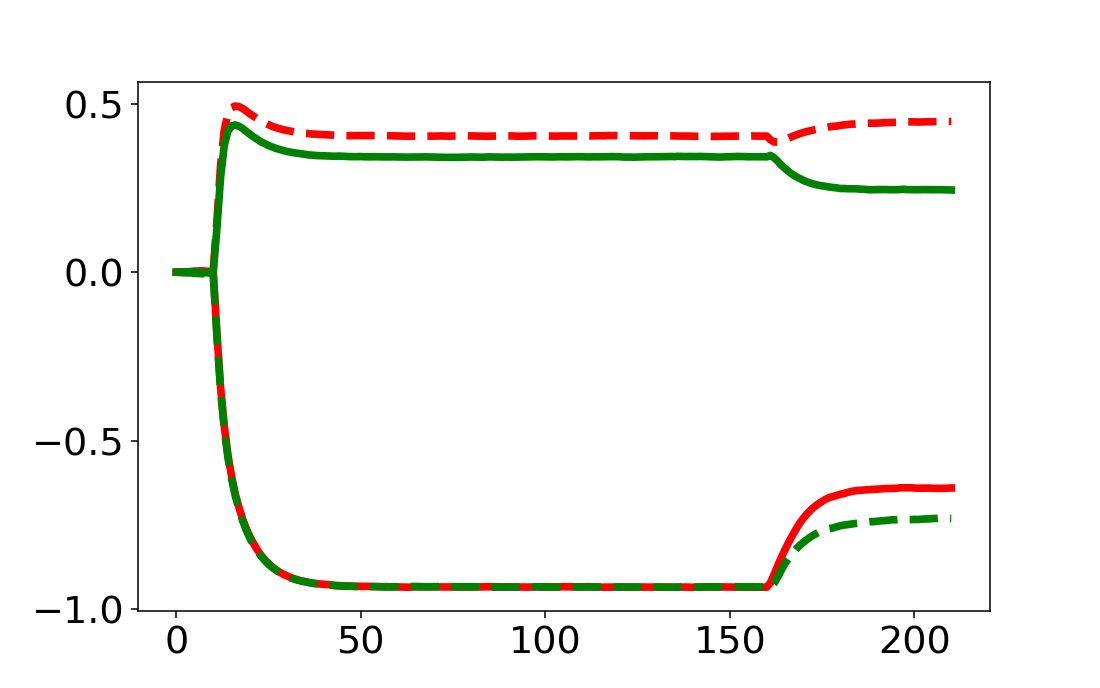

<IPython.core.display.Javascript object>


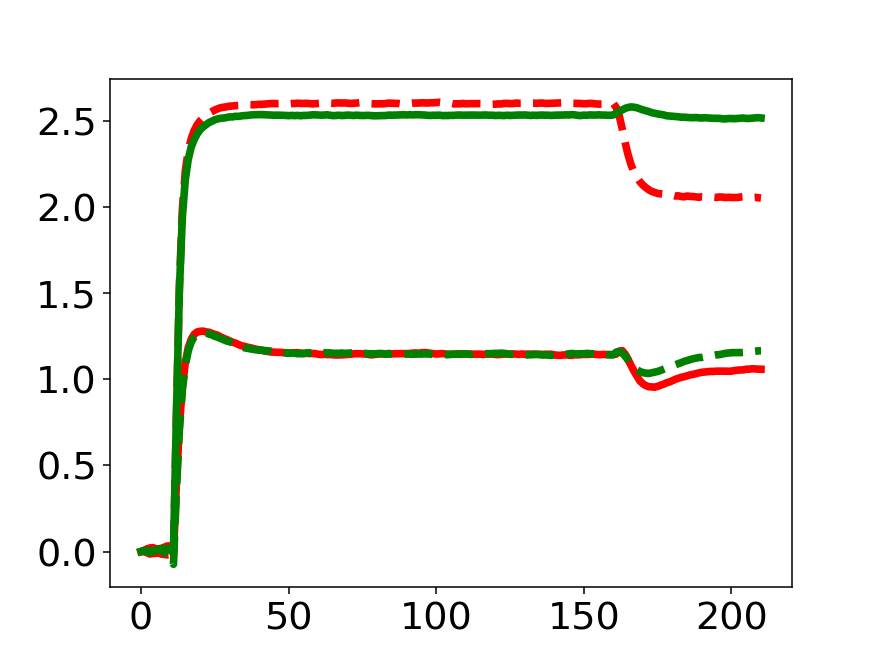

<IPython.core.display.Javascript object>


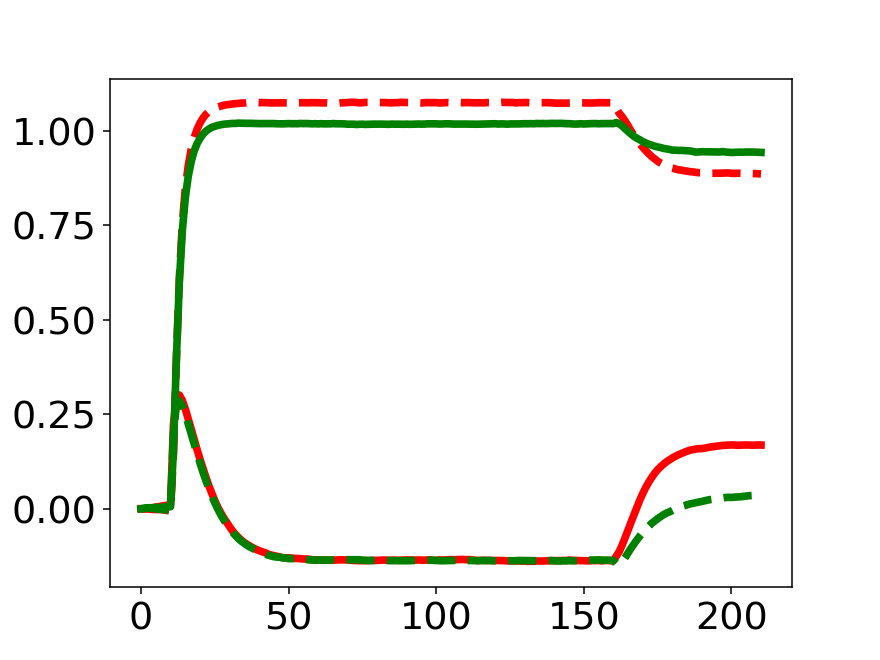

<IPython.core.display.Javascript object>


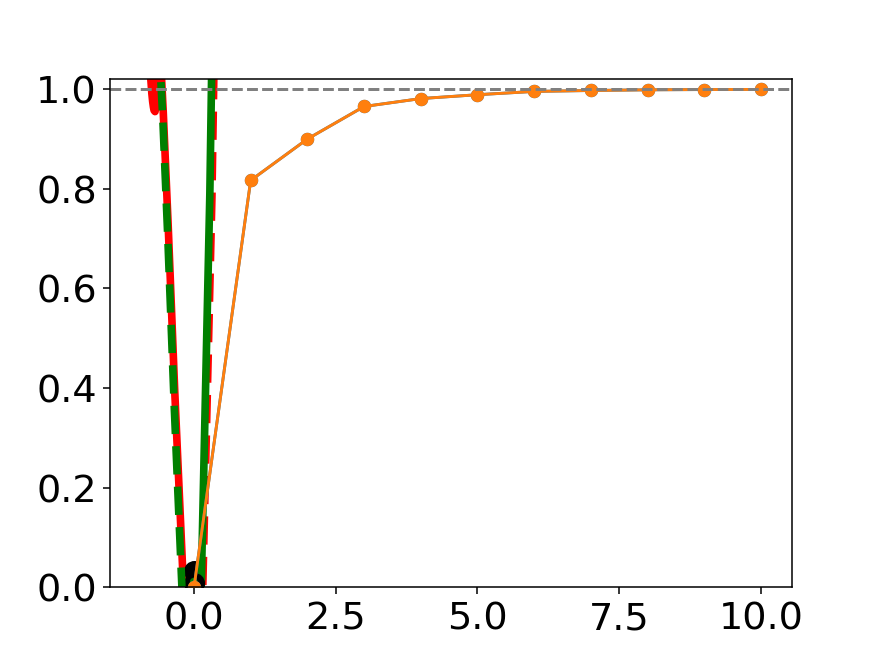

In [40]:
TOn = 10
COn = 160


# project low rank rnn traj on m1 vector
kap1_2 = trajLow @ m1 / size
kap2_2 = trajLow @ m2 / size
kap3_2 = trajLow @ m3 / size


plt.subplots(figsize=(8,5))
colors = ['red', 'red', 'green', 'green']
lineStyle = ['-', '--', '-', '--']

for i in range(4):
#      plt.plot(kap1[i], kap2[i], c=colors[i], lw=4, ls = lineStyle[i])
    plt.plot(kap1_2[i], c=colors[i], lw=4, ls=lineStyle[i])
plt.show()

plt.figure()
for i in range(4):
#      plt.plot(kap1[i], kap2[i], c=colors[i], lw=4, ls = lineStyle[i])
    plt.plot(kap2_2[i], c=colors[i], lw=4, ls=lineStyle[i])
plt.show()

plt.figure()
for i in range(4):
#      plt.plot(kap1[i], kap2[i], c=colors[i], lw=4, ls = lineStyle[i])
    plt.plot(kap3_2[i], c=colors[i], lw=4, ls=lineStyle[i])
plt.figure()
    
for i in range(4):
# #      plt.plot(kap1[i], kap2[i], c=colors[i], lw=4, ls = lineStyle[i])
    plt.plot(kap1_2[i], kap2_2[i], c=colors[i], lw=4, ls=lineStyle[i])
    plt.plot(kap1_2[i, TOn], kap2_2[i, TOn], c='black', marker='.', markersize = 20)
    plt.plot(kap1_2[i, COn], kap2_2[i, COn], c='magentA', marker='.', markersize = 20)


<IPython.core.display.Javascript object>


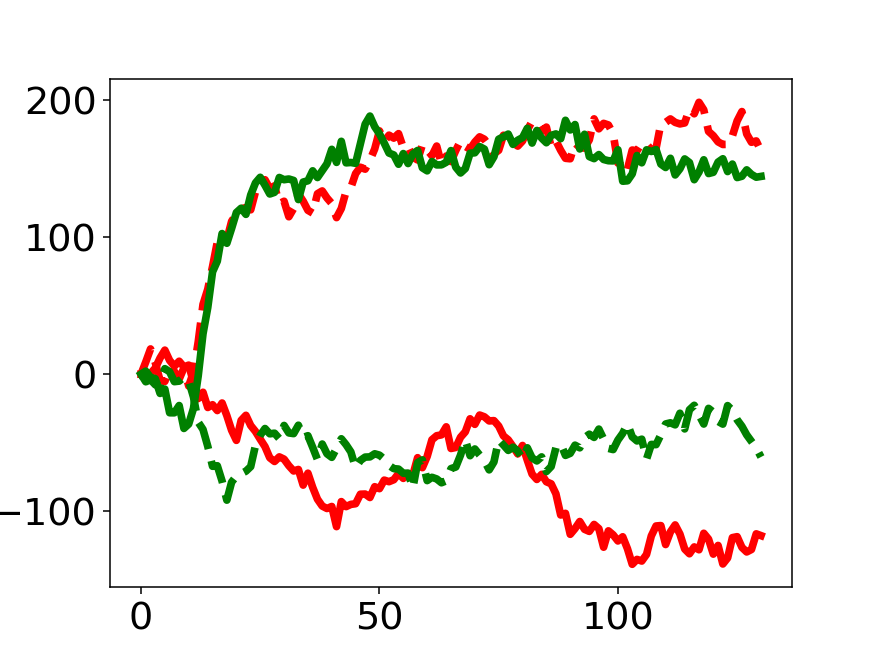

<IPython.core.display.Javascript object>


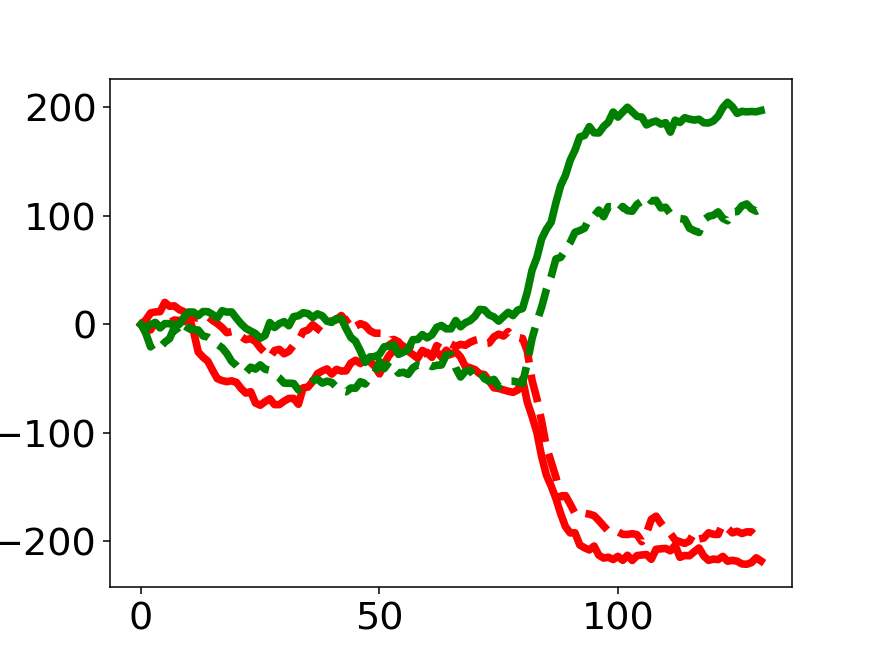

<IPython.core.display.Javascript object>


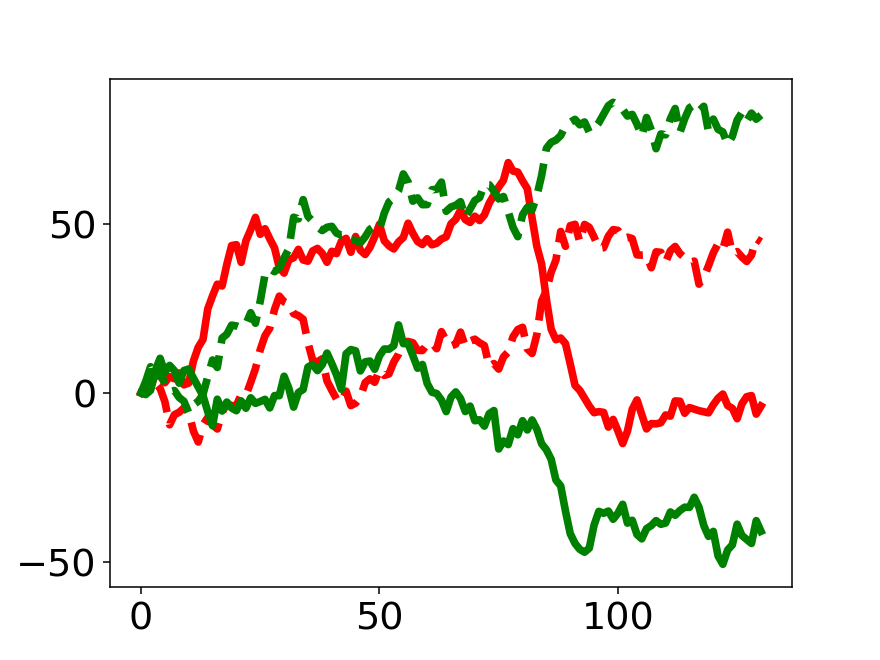

<IPython.core.display.Javascript object>


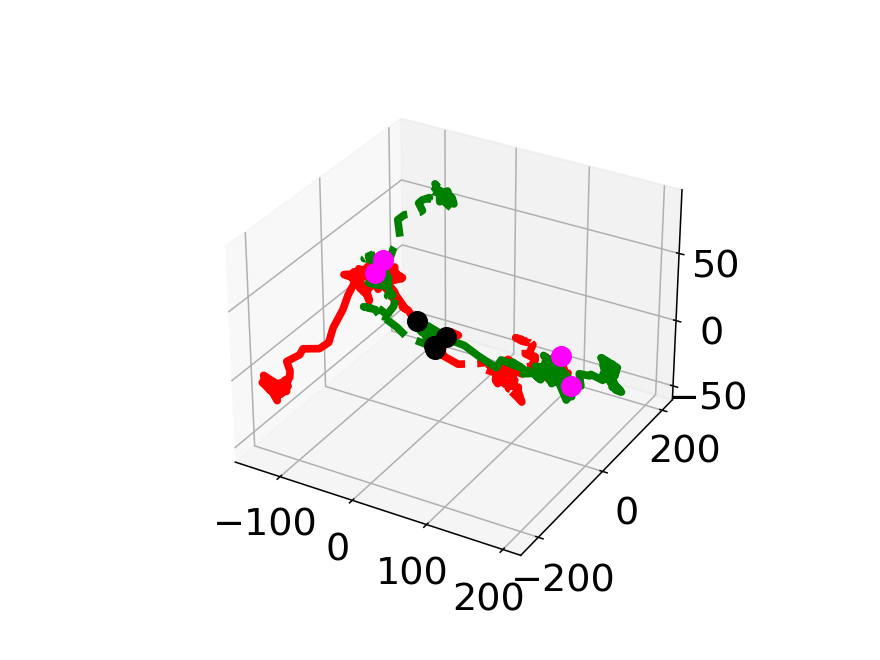

In [61]:
# full rank RNN pca
colors = ['red', 'red', 'green', 'green']
lineStyle = ['-', '--', '-', '--']
TOn = 10
COn = 80


ax1 = m_dpca[:,0]
ax2 = m_dpca[:,1]
ax3 = m_dpca[:,2]


k1 = trajFull @ ax1
k2 = trajFull @ ax2
k3 = trajFull @ ax3

plt.figure()
for i in range(4):
    plt.plot(k1[i], c=colors[i], lw=4, ls = lineStyle[i], label=labels[i])
plt.show()

plt.figure()
for i in range(4):
    plt.plot(k2[i], c=colors[i], lw=4, ls = lineStyle[i], label=labels[i])
plt.show()

plt.figure()
for i in range(4):
    plt.plot(k3[i], c=colors[i], lw=4, ls = lineStyle[i], label=labels[i])
plt.show()


# 3D pca plot
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for i in range(4):
    plt.plot(k1[i], k2[i], k3[i], c=colors[i], lw=4, ls = lineStyle[i])
    ax.scatter(k1[i, TOn], k2[i, TOn], k3[i, TOn], c='black',
            marker='.', s=400)
    ax.scatter(k1[i, COn], k2[i, COn], k3[i, COn], c= 'magenta',
            marker='.', s=400)

# ax.view_init(elev=38, azim=90)
plt.show()

(844, 100)


<IPython.core.display.Javascript object>


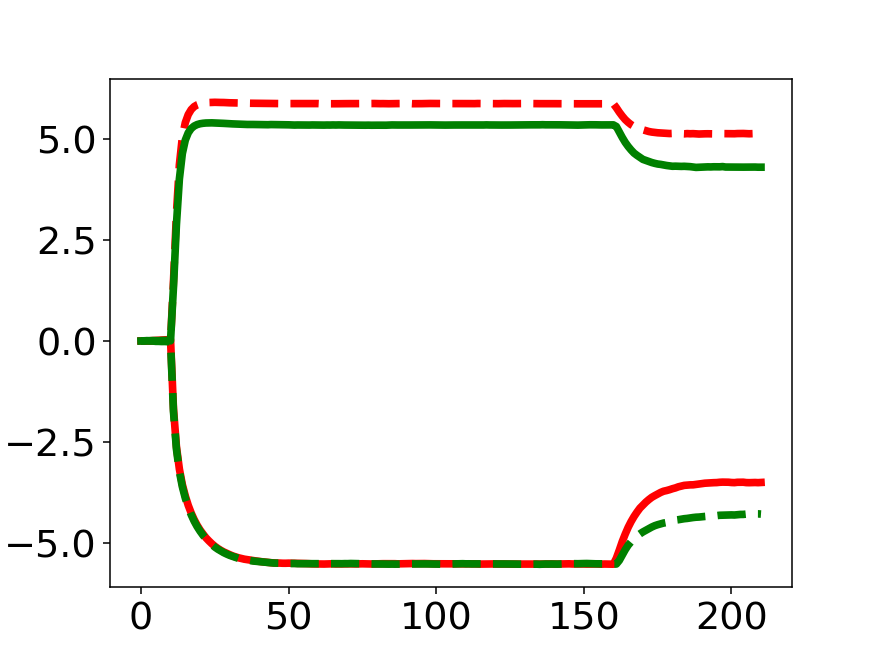

<IPython.core.display.Javascript object>


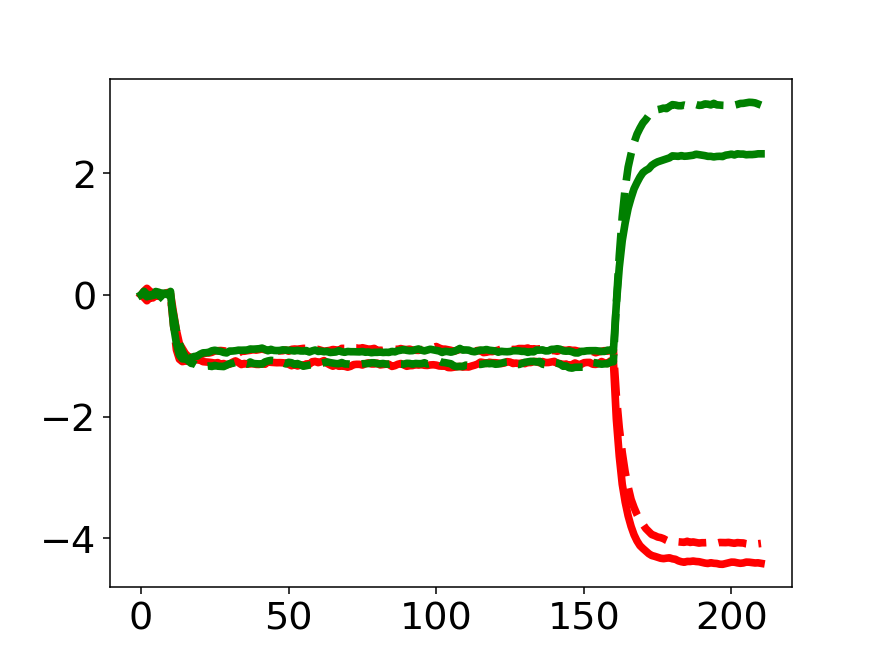

<IPython.core.display.Javascript object>


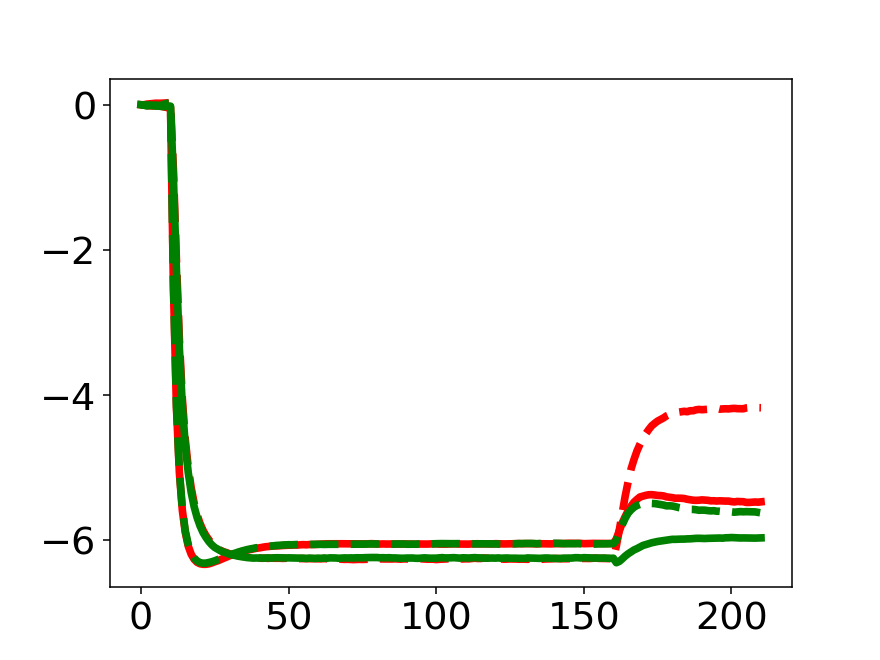

<IPython.core.display.Javascript object>


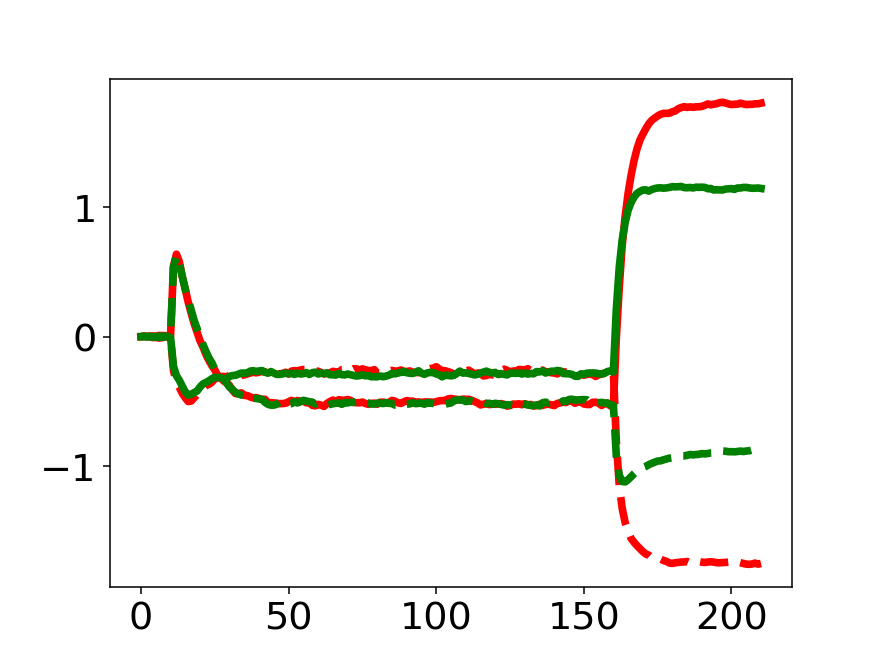

<IPython.core.display.Javascript object>


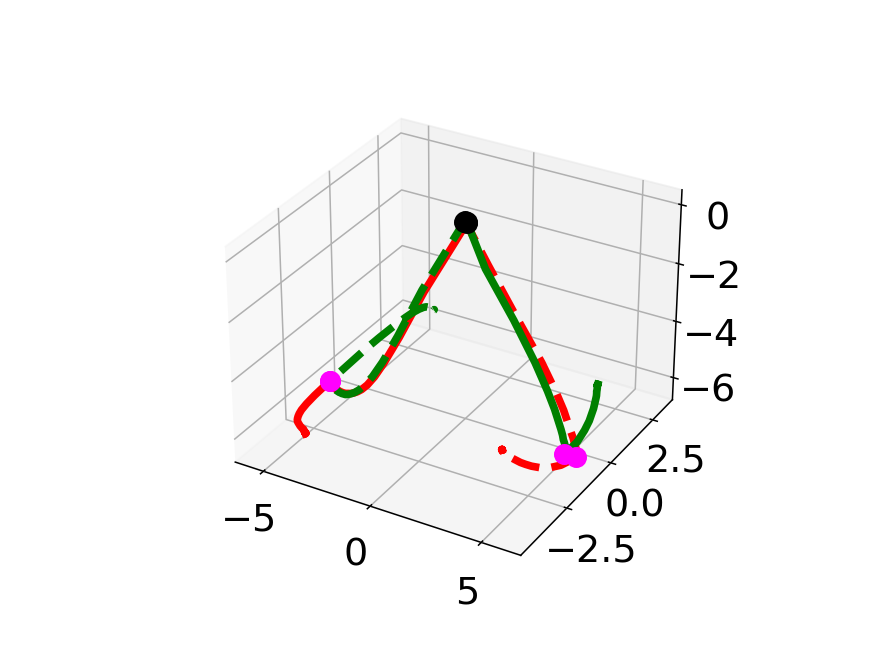

In [42]:
# low rank RNN dpca


# low rank RNN pca
pca = plot.pca_cumvar(trajLow, n_components=10)
plt.ylim(0, 1.02)
plt.axhline(1, ls='--', c='gray')
plt.show()

labels = ['RL', 'RR', 'GL', 'GR']

ax1 = pca.components_[0]
ax2 = pca.components_[1]
ax3 = pca.components_[2]
ax4 = pca.components_[3]


k1 = trajLow @ ax1
k2 = trajLow @ ax2
k3 = trajLow @ ax3
k4 = trajLow @ ax4

plt.figure()
for i in range(4):
    plt.plot(k1[i], c=colors[i], lw=4, ls = lineStyle[i], label=labels[i])
plt.show()

plt.figure()
for i in range(4):
    plt.plot(k2[i], c=colors[i], lw=4, ls = lineStyle[i], label=labels[i])
plt.show()

plt.figure()
for i in range(4):
    plt.plot(k3[i], c=colors[i], lw=4, ls = lineStyle[i], label=labels[i])
plt.show()

plt.figure()
for i in range(4):
    plt.plot(k4[i], c=colors[i], lw=4, ls = lineStyle[i], label=labels[i])
plt.show()

# 3D pca plot
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for i in range(4):
    plt.plot(k1[i], k2[i], k3[i], c=colors[i], lw=4, ls = lineStyle[i])
    ax.scatter(k1[i, TOn], k2[i, TOn], k3[i, TOn], c='black',
            marker='.', s=400)
    ax.scatter(k1[i, COn], k2[i, COn], k3[i, COn], c= 'magenta',
            marker='.', s=400)

# ax.view_init(elev=38, azim=90)
plt.show()

<IPython.core.display.Javascript object>


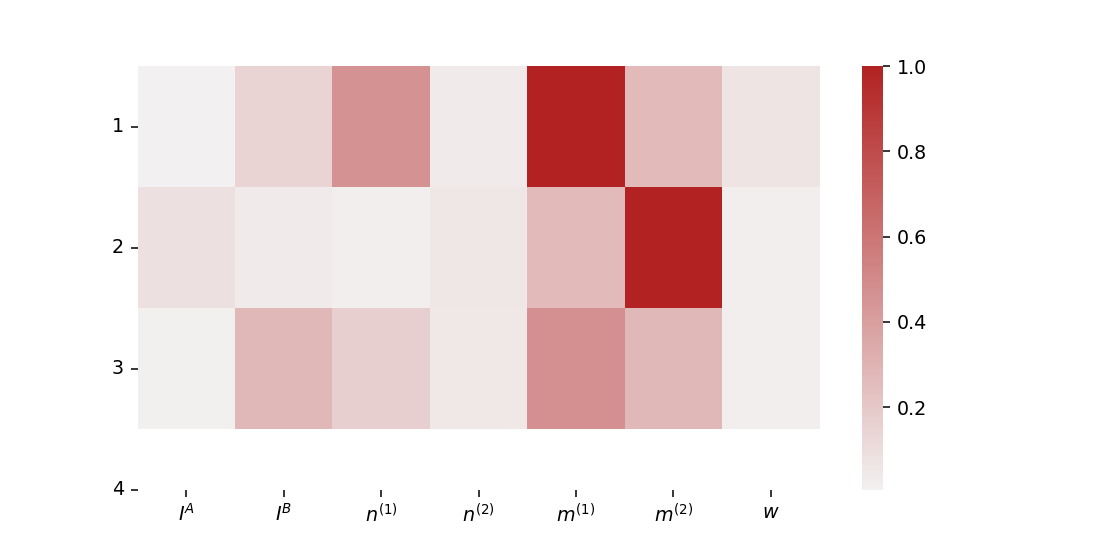

In [22]:
vecs_pca = [ax1, ax2, ax3]
vecs_fit = [wi1, wi2, n1, n2, m1, m2, wo]

helpers.overlap_matrix2(vecs_pca, vecs_fit, norm='l2', figsize=(8,4), abs=True, cmap='abs')
# plt.xlabel('Fitted connectivity')
# plt.ylabel('TDR axes')
plt.xticks(np.arange(0.5, 7, 1), ['$I^A$', '$I^B$', '$n^{(1)}$', '$n^{(2)}$', '$m^{(1)}$', '$m^{(2)}$', '$w$'])
plt.yticks(np.arange(0.5, 4, 1), ['1', '2', '3', '4'], rotation='horizontal')
plt.show()

# Fields

<IPython.core.display.Javascript object>


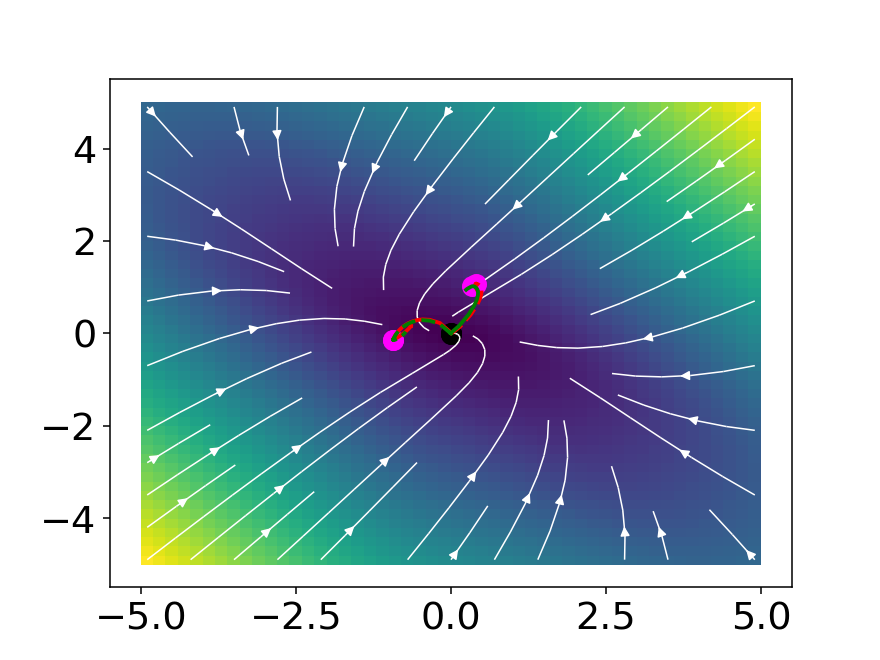

In [43]:
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
ranktwo.plot_field(net_lo, m1, m3, -5, 5, -5, 5)
for i in range(4):
     plt.plot(kap1_2[i], kap3_2[i], c=colors[i], lw=2, ls=lineStyle[i])
     plt.scatter(kap1_2[i, TOn], kap3_2[i, TOn], c= 'black',
            marker='.', s=400)  
     plt.scatter(kap1_2[i, COn], kap3_2[i, COn], c= 'magenta',
            marker='.', s=400)    
plt.show()

# connectivity

<IPython.core.display.Javascript object>


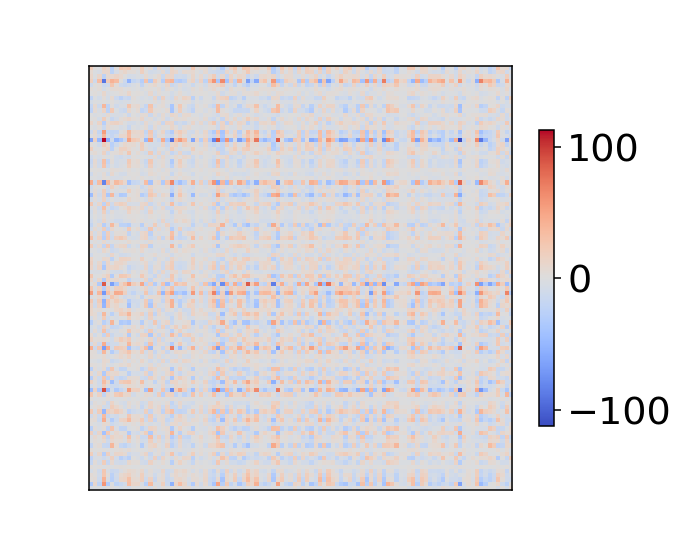

In [35]:
J = (net_lo.m @ net_lo.n.T).detach().numpy()
fig, ax = plt.subplots(figsize=(5,4))
ax.spines['right'].set_visible(True)
ax.spines['top'].set_visible(True)
p = ax.matshow(J, cmap='coolwarm')
ax.set_xticks([])
ax.set_yticks([])
ax_cb = fig.colorbar(p, shrink=.7)
# ax_cb.set_ticks([-20, 0, 20])

norm = ax_cb.norm

<IPython.core.display.Javascript object>


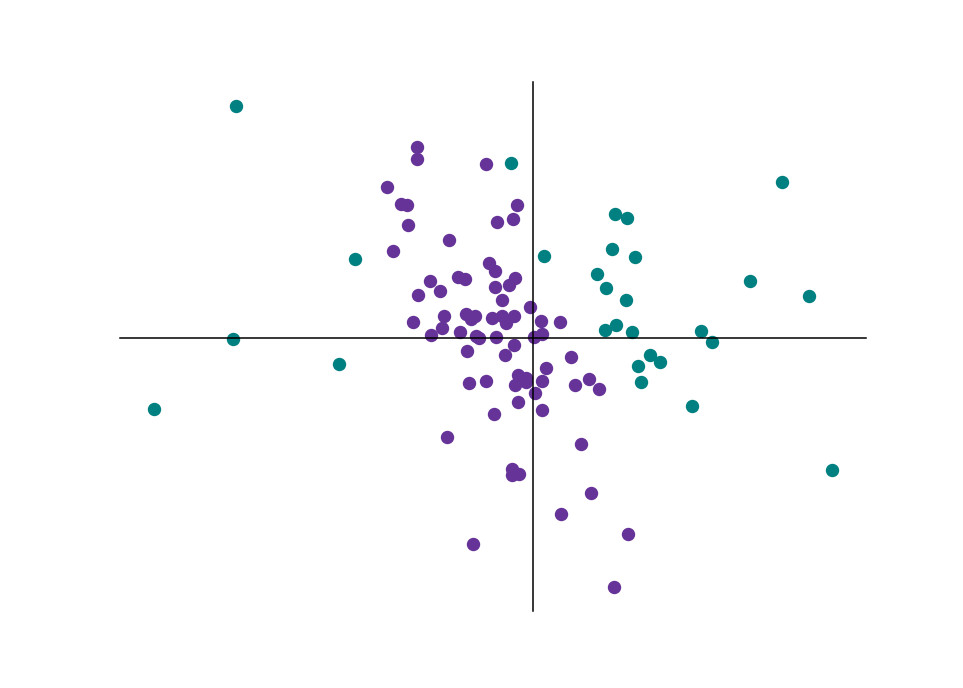

In [44]:
z, _ = clustering.gmm_fit([m1, m2], 4)
colors = ['rebeccapurple', 'teal', 'goldenrod', 'firebrick']
fig, ax = plt.subplots(figsize=(7,5))
for i in range(4):
    ax.scatter(m1[z==i], m2[z==i], c=colors[i])
plot.center_axes(ax)